In this program we will solve a reaction diffusion equation based on your input. 
The equation we work with is as follows:

# Diffusion equation: 
\begin{equation}
    u_{i,k+1} - D(\Delta t)\frac{u_{i-1,k+1}-2u_{i,k+1}+u_{i+1,k+1}}{2(\Delta x)^2}
    = u_{i,k} + D(\Delta t)\frac{u_{i-1,k}-2u_{i,k}+u_{i+1,k}}{2(\Delta x)^2} + (\Delta t)f(x_i,t_k,u_{i,k})
\end{equation}

In [2]:
using Plots

In [6]:
abstract type BoundaryCondition
end

type Dirichlet <: BoundaryCondition 
    ū₀::Float64
    ūₗ::Float64
end

type Neumann <: BoundaryCondition
    ∂ū₀::Float64
    ∂ūₗ::Float64
end 

type Periodic <: BoundaryCondition 
end 

In [7]:
type Discretization
    Nₓ::Int64
    Δx::Float64
    Nₜ::Int64
    Δt::Float64
end 

type SpaceTime
    L::Float64
    tf::Float64
end

In [8]:
"""
Determine the number of spatial unknowns at each time step.
"""
function nb_spatial_unknowns(discretization::Discretization, bc::BoundaryCondition)
    if typeof(bc) == Neumann
        return discretization.Nₓ
    elseif typeof(bc) == Dirichlet
        return discretization.Nₓ - 2
    elseif typeof(bc) == Periodic
        return discretization.Nₓ - 1
    end
end

nb_spatial_unknowns

In [9]:
function build_tri_diagonal_matrix(discretization::Discretization, λ::Float64, bc::BoundaryCondition)
    # determine number of unknowns based on boundary condition
    matrix_dim = nb_spatial_unknowns(discretization, bc)
    
    A = zeros(matrix_dim, matrix_dim)
    
    for i = 1:matrix_dim
        A[i, i] = 1 + 2 * λ
    end
        
    for i = 1:matrix_dim - 1
        A[i  , i+1] = -λ
        A[i+1, i  ] = -λ
    end
    
    if typeof(bc) == Periodic
        A[1, end] = -λ
        A[end, 1] = -λ
    end
        
    if typeof(bc) == Neumann
        A[1, 2] = -2 * λ
        A[end, end - 1] = -2 * λ
    end 
    
    return A
        
end

build_tri_diagonal_matrix (generic function with 1 method)

In [10]:
"""

Arguments:
* f: reaction term f(x, t, u)
* u₀: initial condition u₀(x)
* bc::BoundaryCondition: boundary condition
* D::Float64: diffusion coefficient
* Nₓ::Int: number of spatial discretization points
* st::SpaceTime: space-time over which solution to PDE is approximated
"""
function solve_rxn_diffn_eqn(f, u₀, bc::BoundaryCondition, D::Float64, Nₓ::Int, st::SpaceTime)
    # compute Δx, Nₜ, Δt below.
    discretization = Discretization(Nₓ, NaN, 0, NaN)
    
    # ensure that the boundary condition is consistent with the initial condition
    if isa(bc, Dirichlet)
        @assert(bc.ū₀ ≈ u₀(0.0), 
            "The initial condition is inconsistent with Dirichlet boundary condition.")
        @assert(bc.ūₗ ≈ u₀(st.L), 
            "The initial condition is inconsistent with Dirichlet boundary condition.")
    elseif isa(bc, Periodic)
        @assert(u₀(0) ≈ u₀(st.L), 
            "The initial condition is inconsistent with periodic boundary conditions.")
    elseif isa(bc, Neumann)
        #TODO
    end
    
    # discretize space.
    x = collect(linspace(0, st.L, discretization.Nₓ)) # includes end points!
    discretization.Δx = x[2] - x[1]
    @printf("%d points in x-discretization. dx = %f\n", discretization.Nₓ, discretization.Δx)

    # discreteize time.
    discretization.Δt = discretization.Δx ^ 2
    discretization.Nₜ = ceil(Int, st.tf / discretization.Δt)
    @printf("%d points in t-discretization. dt = %f\n", discretization.Nₜ, discretization.Δt)
    
    # nondimensional parameter involved in discreteization
    λ = (D * discretization.Δt) / (2 * (discretization.Δx) ^ 2)
    
    # build tri-diagonal matrix
    A = build_tri_diagonal_matrix(discretization, λ, bc)
    
    nb_unknowns = nb_spatial_unknowns(discretization, bc)
    
    # initialize u at k = 0
    # this u is the value of u(x, t) when t = k - 1 over discretized x points.
    u = u₀.(x)
    
    # trim u and x so that i index corresponds to xᵢ and uᵢ,ₖ
    if typeof(bc) == Neumann
        # all are unknown, no trimming required
    elseif typeof(bc) == Dirichlet
        u = u[2:end-1]
        x = x[2:end-1]
    elseif typeof(bc) == Periodic
        u = u[1:end-1]
        x = x[1:end-1]
    end
    @assert(length(u) == nb_unknowns)
    @assert(length(x) == nb_unknowns)
    
    # initialize right-hand side of matrix eqn. solved at each time step.
    rhs = zeros(Float64, nb_unknowns)

    # take time steps.
    for k = 1:discretization.Nₜ
        # time here, inside the loop
        t = Δt * k
        
        # build right-hand side vector of matrix eqn.
        for i = 1:nb_unknowns
            # contribution from first order discretization of time derivative
            rhs[i] = u[i]
            # contribution from reaction term
            rhs[i] += f(x[i], t, u[i]) * discretization.Δt
            # TODO contribution from advection 
            # contribution from spatial Laplacian
            if (i != 1) && (i != nb_unknowns)
                rhs[i] += λ * (u[i - 1] - 2 * u[i] + u[i + 1])
            end
        end
        
        # based on boundary condition, handle first and last component of Laplacian.
        if typeof(bc) == Neumann
            rhs[1] += λ * (-4.0 * discretization.Δx * bc.∂ū₀ + 2 * u[2] - 2 * u[1])
            rhs[end] += # TODO
        elseif typeof(bc) == Dirichlet
            # Simply input the known boundary condition for Dirichlet
            rhs[1] += λ * (bc.ū₀ - 2 * u[1] + u[2])
            rhs[end] += λ * (u[end - 1] - 2 * u[end] + bc.̄uₗ)
        elseif typeof(bc) == Periodic
            # draw a circle to see.
            # u[-1] is actually u[end] by PBCs
            rhs[1] += λ * (u[end] - 2 * u[1] + u[2])
            # u[end+1] is actually end
            rhs[end] += λ * (u[end - 1] - 2 * u[end] + u[1])
        end
        # solve for u at next time step (overwrite previous)
        u = A \rhs
        
        # TODO store u and t every so often so we can plot.
    end
       
    ## Making right hand side to fill in the rest of u ##
    if typeof(bc) == Dirichlet
        u[1,:] = bc.ū₀
        u[end,:] = bc.ūₗ
        rhs = zeros(Float64, discretization.Nₓ - 2)
        for k = 2:discretization.Nₜ #this is the column of the u array, not the tₖ  
            for i = 2:(discretization.Nₓ - 1) 
                rhs[i-1] = λ * (u[i - 1, k - 1] - 2 * u[i, k - 1] + u[i + 1, k - 1]) + 
                f(x[i], t[k - 1], u[i, k - 1]) * discretization.Δt + u[i, k - 1] 
            end
        u[2:end-1, k] = A \ rhs       #Au = rhs
        end
    end
    
    if typeof(bc) == Periodic 
        rhs = zeros(Float64, discretization.Nₓ - 1)
         for k = 2:discretization.Nₜ #this is the column of the u array, not the tₖ  
            for i = 1:(discretization.Nₓ - 1) 
                if (i == 1)
                    rhs[i] = λ * (u[Nₓ - 1, k - 1] - 2 * u[i, k - 1] + u[i + 1, k - 1]) + f(x[i], t[k - 1], u[i, k - 1]) * discretization.Δt + u[i, k - 1] 
                else
                    rhs[i] = λ * (u[i - 1, k - 1] - 2 * u[i, k - 1] + u[i + 1, k - 1]) + f(x[i], t[k - 1], u[i, k - 1]) * discretization.Δt + u[i, k - 1]
                end
            end
        u[2:end, k] = A \ rhs       #Au = rhs
        end
    end
     
    
    if typeof(bc) == Neumann 
        rhs = zeros(Float64, discretization.Nₓ)
        for k = 2:discretization.Nₜ #this is the column of the u array, not the tₖ  
            for i = 1:(discretization.Nₓ) 
                if (i == 1)
                    rhs[i] = λ * ((-4 * discretization.Δx * bc.∂ū₀) + 2*u[i + 1, k - 1] - 2 * u[i, k - 1]) + f(x[i], t[k - 1], u[i, k - 1]) * discretization.Δt + u[i, k - 1]
                elseif (i == discretization.Nₓ)
                    rhs[i] = λ * ((4 * discretization.Δx * bc.∂ūₗ) + 2*u[i - 1, k - 1] - 2 * u[i, k - 1])  + f(x[i], t[k - 1], u[i, k - 1]) * discretization.Δt + u[i, k - 1]
                else
                    rhs[i] = λ * (u[i - 1] - 2 * u[i] + u[i + 1]) + f(x[i], t, u[i]) * discretization.Δt + u[i, k - 1]
                end
            end
        u[:, k] = A \ rhs       #Au = rhs
        end

    end 
    
        
    return t, x, u 
    
end 

LoadError: [91msyntax: invalid character "̄"[39m

Enter the following: 

Reaction Term (f(x, t, u))

Initial Condition (u₀)

Boundary Conditions (ū₀ and ūₗ)

Diffusion Coefficient (D)

Number of Spacial Steps (Nₓ)

Length of Simulation (tf) - should be space time?

In [5]:
#Neumann BC Test

g(x::Float64) = x^3

function exact_u(x::Float64, t::Float64) 
    return e^(-π^2 * t) * cos(π * x) + g(x)
end

f(x::Float64, t::Float64, u::Float64) = -g(x)
u₀(x::Float64) = cos(π * x) + g(x)

#f

In [6]:
bc = Neumann(0.0, 3.0)
D = 1.0
Nₓ = 20
st = SpaceTime(1.0, 1.0)

t, x, u = solve_rxn_diffn_eqn(f, u₀, bc, D, Nₓ, st)

20 points in x-discretization. dx = 0.052632
362 points in t-discretization. dt = 0.002770


([0.0, 0.00277008, 0.00554017, 0.00831025, 0.0110803, 0.0138504, 0.0166205, 0.0193906, 0.0221607, 0.0249307  …  0.975069, 0.977839, 0.980609, 0.98338, 0.98615, 0.98892, 0.99169, 0.99446, 0.99723, 1.0], [0.0, 0.0526316, 0.105263, 0.157895, 0.210526, 0.263158, 0.315789, 0.368421, 0.421053, 0.473684, 0.526316, 0.578947, 0.631579, 0.684211, 0.736842, 0.789474, 0.842105, 0.894737, 0.947368, 1.0], [1.0 0.973762 … 2.52526 2.53288; 0.986507 0.961017 … 2.52907 2.53669; … ; -0.136092 -0.0962921 … 3.79685 3.80447; 0.0 0.0403178 … 3.94956 3.95717])

In [8]:
#Dirichlet BC Test
function exact_u(x::Float64, t::Float64) 
        return 100 * exp(-t) * sin(π * x) #exp(-2 * t) * sin(5 * π * x) #Let L = 1
end

f(x::Float64, t::Float64, u::Float64) = 100 * (D * π^2 - 1.0) * (e ^ (-t)  * sin(π * x))
u₀(x::Float64) = 100 * sin(π * x)

bc = Dirichlet(0.0,0.0)
D = 1.0
Nₓ = 20
st = SpaceTime(1.0, 1.0)

t, x, u = solve_rxn_diffn_eqn(f, u₀, bc, D, Nₓ, st)

20 points in x-discretization. dx = 0.052632
362 points in t-discretization. dt = 0.002770


([0.0, 0.00277008, 0.00554017, 0.00831025, 0.0110803, 0.0138504, 0.0166205, 0.0193906, 0.0221607, 0.0249307  …  0.975069, 0.977839, 0.980609, 0.98338, 0.98615, 0.98892, 0.99169, 0.99446, 0.99723, 1.0], [0.0, 0.0526316, 0.105263, 0.157895, 0.210526, 0.263158, 0.315789, 0.368421, 0.421053, 0.473684, 0.526316, 0.578947, 0.631579, 0.684211, 0.736842, 0.789474, 0.842105, 0.894737, 0.947368, 1.0], [0.0 0.0 … 0.0 0.0; 16.4595 16.4155 … 6.09574 6.07888; … ; 16.4595 16.4155 … 6.09574 6.07888; 0.0 0.0 … 0.0 0.0])

In [7]:
 ## Making gif to compare exact equation and rxn_diffn_equ ##

Nₜ=ceil(Int, tf / Δt)

@gif for i = 1:200:Nₜ
    scatter(x,u[:,i], ylim=(0,100), label="numerical", xlabel="x", ylabel="u", title=@sprintf("t = %.2f", t[i]))
    plot!(x, exact_u.(x,t[i]), label="exact")
end 

LoadError: [91mUndefVarError: tf not defined[39m

In [9]:
import PyPlot; const plt = PyPlot

PyPlot

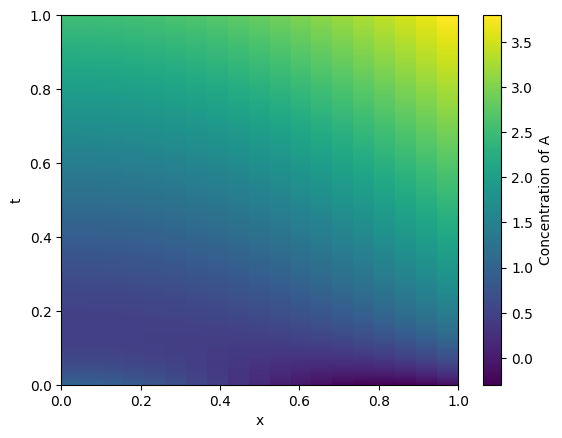

PyObject <matplotlib.colorbar.Colorbar object at 0x000000002FD34BE0>

In [10]:
## Create a heat map ##
Nₜ = length(t)


X = similar(transpose(u))
T = similar(transpose(u))

for i = 1:Nₜ
    X[i,:] = x
end

for i = 1:Nₓ
    T[:,i] = t
end

plt.figure()
plt.pcolormesh(X,T, transpose(u))
plt.xlabel("x")
plt.ylabel("t")
plt.colorbar(label="Concentration of A")

In [12]:
u_e = zeros(Float64, Nₓ, Nₜ)
for i = 1:Nₓ 
    for j = 1:Nₜ
        u_e[i,j] = exact_u(x[i], t[j])
    end
end

function draw_heat_map(x, t, u)
    Nₜ = length(t)

    X = similar(transpose(u))
    T = similar(transpose(u))

    for i = 1:Nₜ
        X[i,:] = x
    end

    for i = 1:Nₓ
        T[:,i] = t
    end

    plt.figure()
    plt.pcolormesh(X,T, transpose(u))
    plt.xlabel("x")
    plt.ylabel("t")
    plt.colorbar(label="Concentration of A")
end 

draw_heat_map (generic function with 1 method)

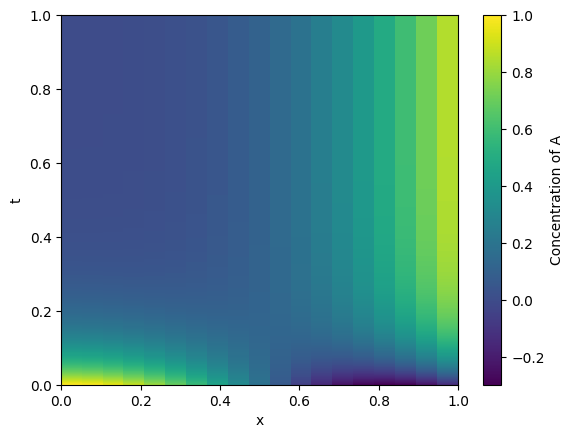

PyObject <matplotlib.colorbar.Colorbar object at 0x000000000943FD30>

In [13]:
draw_heat_map(x,t,u_e)